<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3b_OSI_SAF_sea_ice_mapping_ice_edge.ipynb" target="_blank"><< Mapping OSI SAF sea ice edge</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3d_OSI_SAF_sea_ice_mapping_ice_drift.ipynb" target="_blank">Mapping OSI SAF sea ice drift >></a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2023 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sea-ice/HEAD?urlpath=%2Ftree%2F1_OSI_SAF_sea_ice_introductory%2F1_3c_OSI_SAF_sea_ice_mapping_ice_type.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea ice parameters : Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb" target="_blank">1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb</a>**

</div>
<hr>

# 1.3c Mapping OSI SAF sea ice type 
### Data used 

| Product Description | Product Navigator | OSI SAF website link | OSI SAF Identifier |
|:--------------------:|:-------------:|:-----------------:|:-----------------:|
| Global Sea Ice Type | EO:EUM:DAT:MULT:OSITYGBN | <a href="https://osi-saf.eumetsat.int/products/osi-403-d" target="_blank">link</a> | OSI-403-d | 


### Learning outcomes

At the end of this notebook you will know;
* How to open Sea Ice Type netcdf
* Map Sea Ice Type using cartopy 


<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Mapping sea ice type - Northern Hemisphere](#section1)
 1. [Mapping sea ice type - Southern Hemisphere](#section2)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports 
import os                                     # a library that allows us access to basic operating system commands
import xarray as xr                           # a library that supports the use of multi-dimensional arrays in Python
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_cm
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean                                # colormaps for ocean products
import cmcrameri                              # scientific colormaps for data visualisation

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Mapping sea ice type - Northern Hemisphere
[Back to top](#TOC_TOP)

</div>

Setting directory where to read data files

In [2]:
directory = 'products/sea_ice_type/nh/'

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.hoosing color palet

In [3]:
cmap = mpl_cm.get_cmap('jet')
#cmap = cmocean.cm.ice
#cmap = cmcrameri.cm.nuuk

Let's explore the netcdf file to find out about its characteristics.

In [4]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(directory + '/' + filename)

In [5]:
nc

<xarray.Dataset>
Dimensions:                   (time: 1, nv: 2, xc: 760, yc: 1120)
Coordinates:
  * time                      (time) datetime64[ns] 2023-02-05T12:00:00
  * xc                        (xc) float64 -3.84e+03 -3.83e+03 ... 3.74e+03
  * yc                        (yc) float64 5.84e+03 5.83e+03 ... -5.34e+03
    lat                       (yc, xc) float32 ...
    lon                       (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Polar_Stereographic_Grid  int32 ...
    time_bnds                 (time, nv) datetime64[ns] ...
    ice_type                  (time, yc, xc) float32 ...
    status_flag               (time, yc, xc) float32 ...
    uncertainty               (time, yc, xc) float32 ...
    param_used                (time, yc, xc) float32 ...
    orbit_num_ascat           (time, yc, xc) float32 ...
    orbit_num_amsr            (time, yc, xc) float32 ...
    orbit_num_ssmis           (time, yc, xc) float32 ...
Attributes: (12/30)
    title:                  Daily Sea Ice Type Analysis from OSI SAF EUMETSAT
    product_id:             OSI-403-d
    product_name:           osi_saf_ice_type
    product_status:         operational
    abstract:               The daily analysis of sea ice types is obtained f...
    topiccategory:          Oceans ClimatologyMeteorologyAtmosphere
    ...                     ...
    references:             OSI SAF Product User's Manual for the Global Sea ...
    history:                2023-02-06 creation
    product_version:        5.0
    software_version:       5.3
    netcdf_version:         4.4.1.1
    Conventions:            CF-1.7

If we explore the ice_edge variable, we find out the ice_dege is represented with 3 values :   
* 1 -> no ice or very open ice
* 2 -> relatively young ice
* 3 -> ice that survived a summer melt
* 4 -> ambiguous ice type

Therefore, before plotting we we will define bins to make our colormap discrete.

In [6]:
# define the bins and normalize
cmap_bounds = np.linspace(0.5, 4.5, 5)
norm = mpl.colors.BoundaryNorm(cmap_bounds, cmap.N)

Mapping figure based on retrieved netcdf file

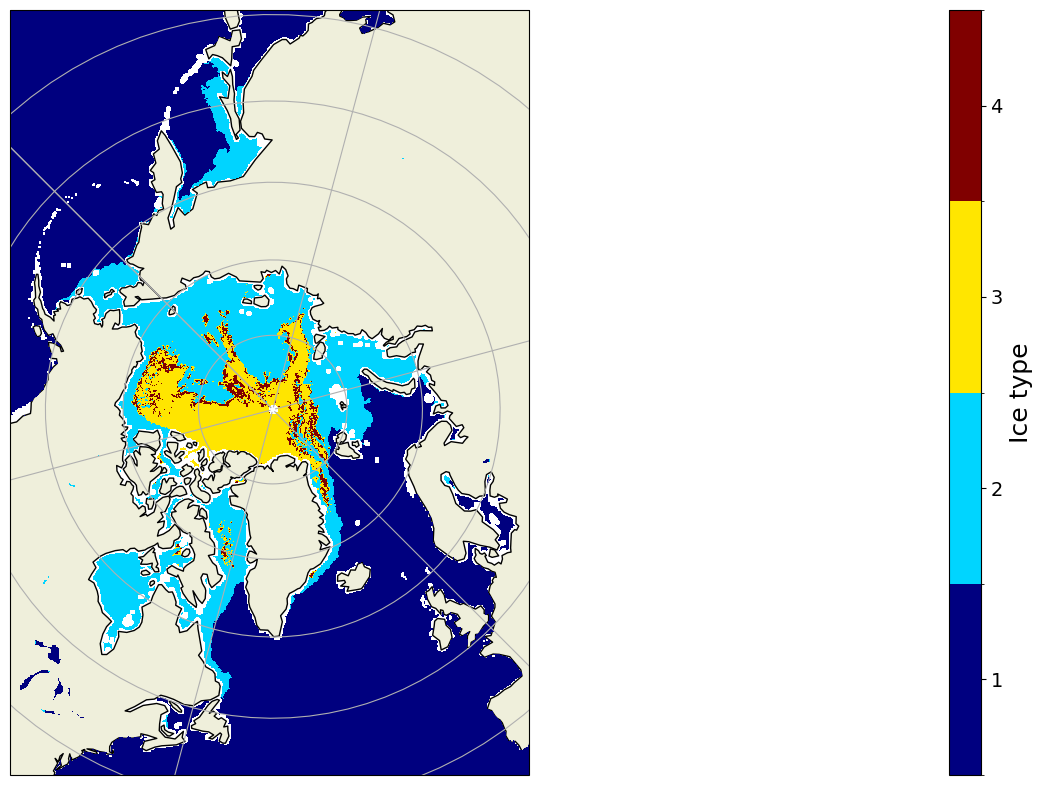

In [7]:
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)
output_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.gridlines()

# open and plot data
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(directory + '/' + filename)
        xc = nc.variables['xc'][:] 
        yc = nc.variables['yc'][:]
        ice_type = nc.variables['ice_type'][:]
        status_flag  = nc.variables['status_flag'][:]
        nc.close()
        
        # Sea Ice Concentration data is provided in x y coordinates, bounds need to be defined for cartopy
        bounds=(xc.min()*1000,xc.max()*1000,yc.min()*1000,yc.max()*1000)
        
        # plotting sea ice
        im = ax.imshow(ice_type[0,:,:], transform=data_projection, extent=bounds, origin='upper', cmap=cmap, norm=norm)

# Adding a colorbar
axc = fig.add_axes((0.85,0.05,0.02,0.85))
cb = plt.colorbar(im, orientation='vertical', cax=axc, ticks=[1, 2, 3, 4])
cb.set_label('Ice type', fontsize=18)
cb.ax.tick_params(labelsize=14)

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Mapping sea ice type - Southern Hemisphere
[Back to top](#TOC_TOP)

</div>

Setting directory where to read data files

In [8]:
directory = 'products/sea_ice_type/sh/'

Choose a colormap for your data set. You can find more information on matplotlib colormaps here. However, we recommend you have a look at cmocean colormaps or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [9]:
cmap = mpl_cm.get_cmap('jet')
#cmap = cmocean.cm.ice
#cmap = cmcrameri.cm.nuuk

Let's explore the netcdf file to find out about its characteristics.

In [10]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(directory + '/' + filename)

In [11]:
nc

<xarray.Dataset>
Dimensions:                   (time: 1, nv: 2, xc: 790, yc: 830)
Coordinates:
  * time                      (time) datetime64[ns] 2023-02-05T12:00:00
  * xc                        (xc) float64 -3.94e+03 -3.93e+03 ... 3.94e+03
  * yc                        (yc) float64 4.34e+03 4.33e+03 ... -3.94e+03
    lat                       (yc, xc) float32 ...
    lon                       (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Polar_Stereographic_Grid  int32 ...
    time_bnds                 (time, nv) datetime64[ns] ...
    ice_type                  (time, yc, xc) float32 ...
    status_flag               (time, yc, xc) float32 ...
    uncertainty               (time, yc, xc) float32 ...
    param_used                (time, yc, xc) float32 ...
    orbit_num_ascat           (time, yc, xc) float32 ...
    orbit_num_amsr            (time, yc, xc) float32 ...
    orbit_num_ssmis           (time, yc, xc) float32 ...
Attributes: (12/30)
    title:                  Daily Sea Ice Type Analysis from OSI SAF EUMETSAT
    product_id:             OSI-403-d
    product_name:           osi_saf_ice_type
    product_status:         operational
    abstract:               The daily analysis of sea ice types is obtained f...
    topiccategory:          Oceans ClimatologyMeteorologyAtmosphere
    ...                     ...
    references:             OSI SAF Product User's Manual for the Global Sea ...
    history:                2023-02-06 creation
    product_version:        5.0
    software_version:       5.3
    netcdf_version:         4.4.1.1
    Conventions:            CF-1.7

If we explore the ice_edge variable, we find out the ice_dege is represented with 3 values :   
* 1 -> no ice or very open ice
* 2 -> relatively young ice
* 3 -> ice that survived a summer melt
* 4 -> ambiguous ice type

Therefore, before plotting we we will define bins to make our colormap discrete.

In [12]:
# define the bins and normalize
cmap_bounds = np.linspace(0.5, 4.5, 5)
norm = mpl.colors.BoundaryNorm(cmap_bounds, cmap.N)

Mapping figure based on retrieved netcdf file

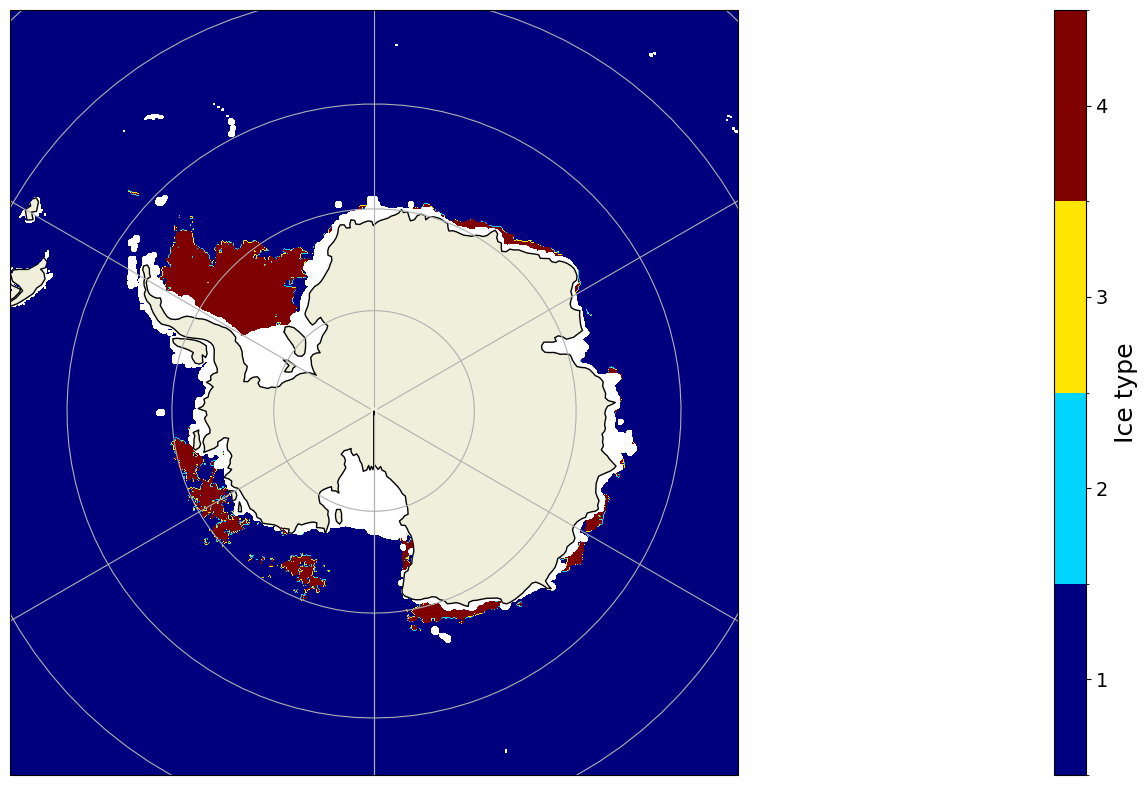

In [13]:
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0.0, true_scale_latitude=-70.0)
output_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0.0, true_scale_latitude=-70.0)

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.gridlines()

# open and plot data
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(directory + '/' + filename)
        xc = nc.variables['xc'][:] 
        yc = nc.variables['yc'][:]
        ice_type = nc.variables['ice_type'][:]
        status_flag  = nc.variables['status_flag'][:]
        nc.close()
        
        # Sea Ice Concentration data is provided in x y coordinates, bounds need to be defined for cartopy
        bounds=(xc.min()*1000,xc.max()*1000,yc.min()*1000,yc.max()*1000)
        
        # plotting sea ice
        im = ax.imshow(ice_type[0,:,:], transform=data_projection, extent=bounds, origin='upper', cmap=cmap, norm=norm)

# Adding a colorbar
axc = fig.add_axes((0.85,0.05,0.02,0.85))
cb = plt.colorbar(im, orientation='vertical', cax=axc, ticks=[1, 2, 3, 4])
cb.set_label('Ice type', fontsize=18)
cb.ax.tick_params(labelsize=14)

You should notice on the figure above, that there are missing areas of data around the Antarctic continent. These correspond to Ice Shelves that are not included directly in cartopy LAND boundaries. So let's add them to the plot.

In [14]:
ice_shelves = cfeature.NaturalEarthFeature(
        category='physical',
        name='antarctic_ice_shelves_polys',
        scale='10m',
        facecolor='grey',
        edgecolor='grey')

Plot with Ice Shelves.

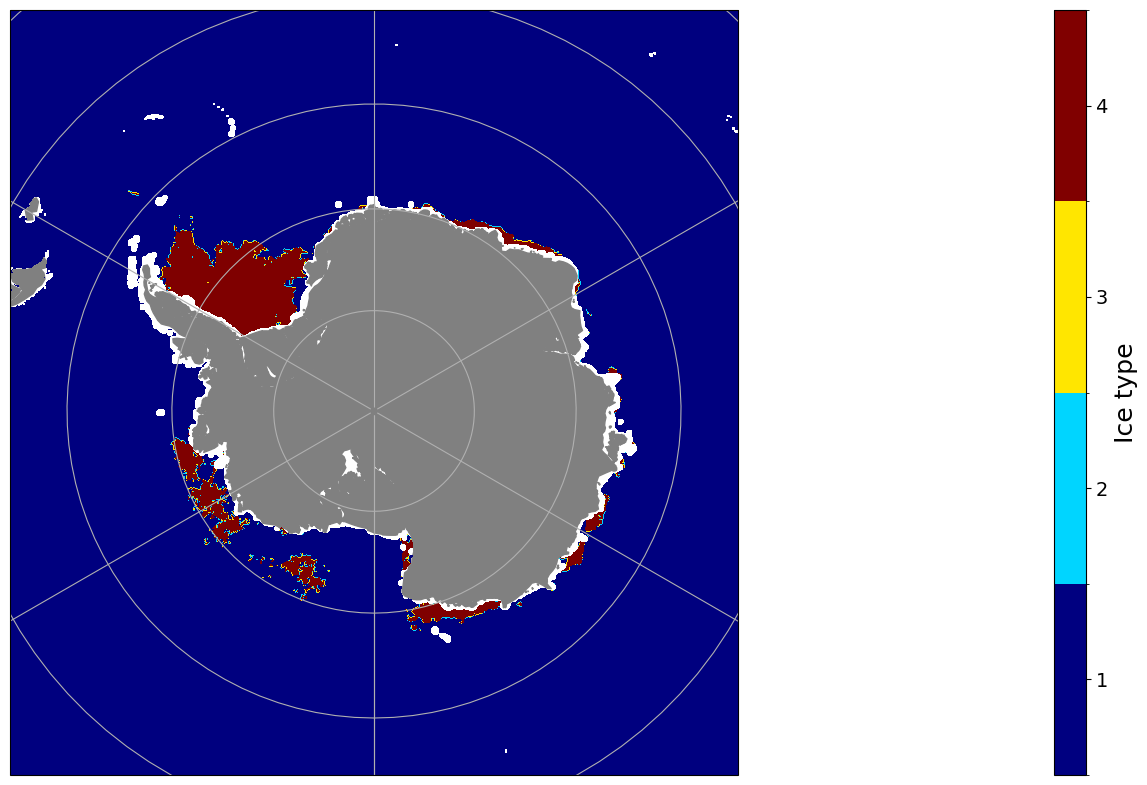

In [15]:
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0.0, true_scale_latitude=-70.0)
output_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0.0, true_scale_latitude=-70.0)

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.add_feature(cfeature.LAND, zorder=0, color='grey')
ax.add_feature(ice_shelves, )
ax.gridlines()

# open and plot data
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(directory + '/' + filename)
        xc = nc.variables['xc'][:] 
        yc = nc.variables['yc'][:]
        ice_type = nc.variables['ice_type'][:]
        status_flag  = nc.variables['status_flag'][:]
        nc.close()
        
        # Sea Ice Concentration data is provided in x y coordinates, bounds need to be defined for cartopy
        bounds=(xc.min()*1000,xc.max()*1000,yc.min()*1000,yc.max()*1000)
        
        # plotting sea ice
        im = ax.imshow(ice_type[0,:,:], transform=data_projection, extent=bounds, origin='upper', cmap=cmap, norm=norm)

# Adding a colorbar
axc = fig.add_axes((0.85,0.05,0.02,0.85))
cb = plt.colorbar(im, orientation='vertical', cax=axc, ticks=[1, 2, 3, 4])
cb.set_label('Ice type', fontsize=18)
cb.ax.tick_params(labelsize=14)

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3b_OSI_SAF_sea_ice_mapping_ice_edge.ipynb" target="_blank"><< Mapping OSI SAF sea ice edge</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3d_OSI_SAF_sea_ice_mapping_ice_drift.ipynb" target="_blank">Mapping OSI SAF sea ice drift >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>